# **Real Estate Price Prediction Project**
---

In [1]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('Bengaluru_House_Data.csv')

---
# **DATA CLEANING**
---

In [2]:
# Drop unnecessary columns
df.drop(["availability", "society"], axis=1, inplace=True)

# Convert 'size' column (e.g., '2 BHK', '4 Bedroom', '1 RK') → numeric
def extract_num(x):
    if pd.isna(x): return np.nan
    num = ''.join([c for c in x if c.isdigit()])
    return int(num) if num else np.nan

df['size'] = df['size'].apply(extract_num)

# Fill missing values via interpolation
df['size'].interpolate(method='linear', inplace=True)
df['bath'].interpolate(method='linear', inplace=True)
df['balcony'].interpolate(method='linear', inplace=True)
df['balcony'] = df['balcony'].round(2)

/tmp/ipython-input-3185002005.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['size'].interpolate(method='linear', inplace=True)
/tmp/ipython-input-3185002005.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [3]:

# Convert total_sqft to numeric (handles Acres, ranges, etc.)
def convert_sqft(x):
    if pd.isna(x): return np.nan
    x = str(x).strip()
    if 'acre' in x.lower():
        num = ''.join(c for c in x if c.isdigit() or c=='.')
        return float(num) * 43560
    if '-' in x:
        nums = x.split('-')
        try: return (float(nums[0].strip()) + float(nums[1].strip())) / 2
        except: return np.nan
    try: return float(x)
    except: return np.nan

print("NaN count BEFORE conversion:", df['total_sqft'].isna().sum())

df['total_sqft'] = df['total_sqft'].apply(convert_sqft)

print("NaN count AFTER conversion:", df['total_sqft'].isna().sum())
df['total_sqft'].interpolate(method='linear', inplace=True)

NaN count BEFORE conversion: 0
NaN count AFTER conversion: 38


/tmp/ipython-input-3976401547.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_sqft'].interpolate(method='linear', inplace=True)


# **FEATURE ENGINEERING**

---
Area Type and location is nominal data(no order) so we covert it to numerical
i can use one hot encoding or dummy to get One-Hot (Dummy Columns) only on the Area type column
---
---
I can't use One hot encoding on the Location column as it makes it having too many features making model becomes overfit as it is too simple for this large number of features. So i used mean encoding it is simple and effective
---
---
i can't use label endcoder as it is for categorial order column which gives only one column ranking
----

In [4]:

# One-hot encode area_type, then drop one to avoid dummy trap
dummies = pd.get_dummies(df['area_type'], dtype=int)
df = pd.concat([df, dummies], axis=1)
df.drop(['area_type', 'Built-up  Area'], axis=1, inplace=True)

# Clean location & drop blanks
df['location'] = df['location'].str.strip().str.lower()
df['location'].replace('', np.nan, inplace=True)
df.dropna(subset=['location'], inplace=True)

# Mean Encoding of location
location_price_map = df.groupby('location')['price'].mean()
df['location_encoded'] = df['location'].map(location_price_map).fillna(location_price_map.mean())
df = df.drop('location', axis=1)

/tmp/ipython-input-896014936.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['location'].replace('', np.nan, inplace=True)


# **Outlier Detection**

In [5]:

# Outlier removal on total_sqft using IQR
q1 = df.total_sqft.quantile(0.25)
q3 = df.total_sqft.quantile(0.75)
IQR = q3 - q1

lower_limit = q1 - 1.5 * IQR
upper_limit = q3 + 1.5 * IQR

df = df[(df.total_sqft > lower_limit) & (df.total_sqft < upper_limit)]


In [6]:
target=df.price
original_price=df.price
df_original=df.copy()

---
**Price was highly skew so used Log scaling then outlier removal**
---

In [7]:
import numpy as np

# Create a new log-transformed price column
df['price_log'] = np.log1p(target)  # log1p means log(price + 1), avoids issues with zero

# If price is your target variable, use price_log instead of price
target = df['price_log']


---
**THis chart is to compare the Target (price) column before the Log scaling and we can see before it was skew and later it was normal bell curve**
---

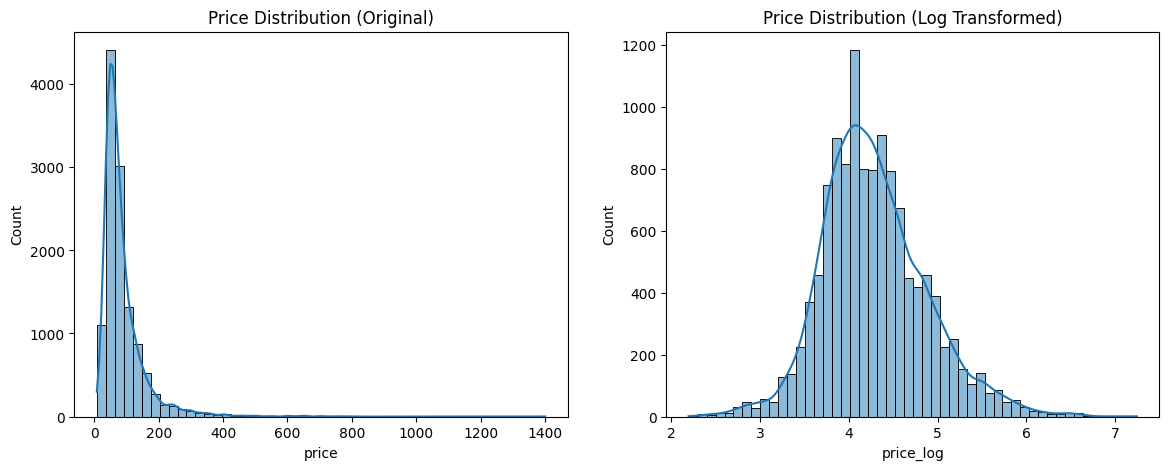

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.histplot(original_price, bins=50, kde=True)
plt.title("Price Distribution (Original)")

plt.subplot(1,2,2)
sns.histplot(target, bins=50, kde=True)
plt.title("Price Distribution (Log Transformed)")

plt.show()


---
**Outlier removeal of the Target Price column**
---


In [9]:
# Assuming original df already has 'price_log'

Q1 = df['price_log'].quantile(0.25)
Q3 = df['price_log'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Keep only rows inside the range
df = df[(df['price_log'] >= lower_limit) & (df['price_log'] <= upper_limit)].copy()


---
 After the outlier removal
 ---

Text(0.5, 1.0, 'Price Distribution (Log Transformed)')

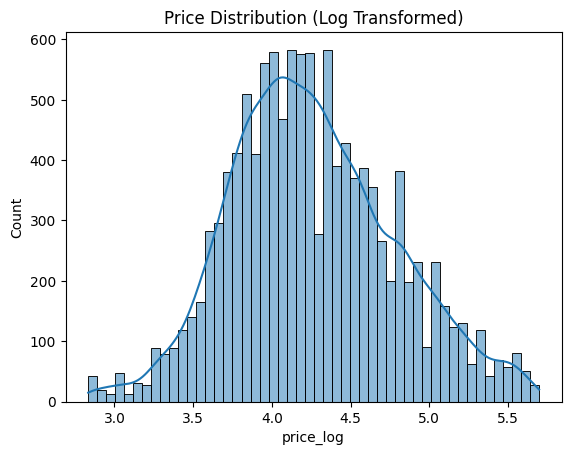

In [10]:
# plt.subplot(1,2,2)
sns.histplot(df['price_log'], bins=50, kde=True)
plt.title("Price Distribution (Log Transformed)")

In [11]:
df.drop("price",axis=1,inplace=True)

In [12]:
y=df.price_log
df.drop("price_log",axis=1,inplace=True)


---
**Using train Test split to split the data for training and testing**
---

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=30)


In [14]:
X_train.head(1)

,size,total_sqft,bath,balcony,Carpet Area,Plot Area,Super built-up Area,location_encoded
11207,2.0,1200.0,2.0,1.0,0,0,1,91.193333


---


# **Principal Component Analysis (PCA)**


---
**Even though I don’t really need it, I’m using Principal Component Analysis (PCA) just for practice. It’s a dimensionality reduction method that helps by reducing the number of features while keeping most of the important information from the data.**
---

In [15]:
from sklearn.preprocessing import StandardScaler

# 2. Scale only on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ✅ Convert back to DataFrames with same column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # Keep 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=30,
    n_jobs=-1
)

# If you're using scaling, do it like this:
rf.fit(X_train_pca, y_train)
print("Train R2:", rf.score(X_train_pca, y_train))
print("Test R2:", rf.score(X_test_pca, y_test))



Train R2: 0.8747775405499469
Test R2: 0.7613999533336379


# Comparing the actual and predict price to know accuracy

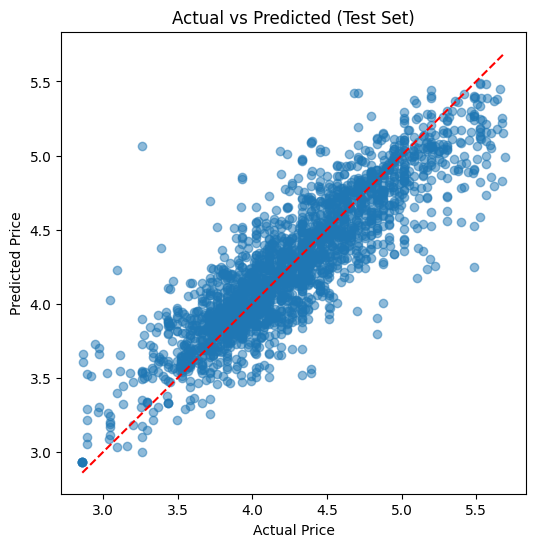

In [17]:
import matplotlib.pyplot as plt

y_pred = rf.predict(X_test_pca)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted (Test Set)")
plt.show()


# **PUTTING MODEL AS PICKLE FILE TO SAVE IT**


In [18]:
import pickle

with open("Real-Estate-Price-Prediction.pickle", "wb") as file:
    pickle.dump(rf, file)


I can use this to load the model back

In [19]:
import pickle

with open("Real-Estate-Price-Prediction.pickle", "rb") as file:
    loaded_model = pickle.load(file)